Notebook to evaluate multihead unet

Detection

In [1]:
import os
from pprint import pprint
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
# import ttach as tta

sys.path.append("../")

from monkey.config import TrainingIOConfig
from monkey.data.dataset import get_detection_dataloaders
from monkey.model.efficientunetb0.architecture import (
    get_multihead_efficientunet,
)
from monkey.model.hovernext.model import get_custom_hovernext
from monkey.model.utils import get_activation_function
from tqdm.autonotebook import tqdm
from monkey.model.utils import (
    get_multiclass_patch_F1_score_batch,
    get_patch_F1_score_batch,
)
from monkey.data.data_utils import imagenet_denormalise, dilate_mask
from monkey.model.hovernext.model import (
    get_convnext_unet,
    get_custom_hovernext,
)
from prediction.utils import multihead_det_post_process_batch, post_process_batch

from torch.amp import autocast

/home/u1910100/miniconda3/envs/tiatoolbox/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/u1910100/miniconda3/envs/tiatoolbox/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
run_config = {
    "val_fold": 1,  # [1-5]
    "activation_function": {
        "head_1": "sigmoid",
        "head_2": "sigmoid",
        "head_3": "sigmoid",
    },
}

IOconfig = TrainingIOConfig(
    dataset_dir="/media/u1910100/data/Monkey/patches_256",
)
IOconfig.set_mask_dir(
    mask_dir="/media/u1910100/data/Monkey/patches_256/annotations/nuclick_masks_processed_v2"
)

# transforms = tta.Compose(
#     [
#         tta.HorizontalFlip(),
#         tta.VerticalFlip(),
#         tta.Rotate90(angles=[0, 180, 90, 270]),
#     ]
# )


models = []
folds = [run_config["val_fold"]]
for i in folds:
    # checkpoint_path = f"/media/u1910100/data/Monkey/runs/cell_multiclass_det/efficientnetv2_s_multitask_det_focal_loss/fold_{i}/best_val.pth"
    checkpoint_path = f"/media/u1910100/data/Monkey/runs/cell_multiclass_det/efficientnetv2_l_multitask_det_decoder_v4/fold_{i}/best_val.pth"
    # checkpoint_path = f"/media/u1910100/data/Monkey/runs/cell_multiclass_det/final_model/fold_{i}/best_f1.pth"
    # model = get_multihead_efficientunet(
    #     out_channels=[1,1,1], pretrained=False
    # )
    model = get_custom_hovernext(
        enc="tf_efficientnetv2_l.in21k_ft_in1k",
        pretrained=False,
        use_batchnorm=True,
        attention_type="scse",
        decoders_out_channels=[3,3,3],
        center=True
    )
    checkpoint = torch.load(checkpoint_path)
    print(checkpoint["epoch"])
    model.load_state_dict(checkpoint["model"])
    model.eval()
    model.to("cuda")
    # model = tta.SegmentationTTAWrapper(model, transforms)
    models.append(model)

# checkpoint_path = f"/home/u1910100/Documents/Monkey/runs/cell_multiclass_det/multihead_unet_512/fold_{run_config['val_fold']}/epoch_30.pth"
# checkpoint = torch.load(checkpoint_path)
# print(checkpoint["epoch"])
# model.load_state_dict(checkpoint["model"])
# model.eval()
# model.to("cuda")


train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=run_config["val_fold"],
    dataset_name="multitask",
    batch_size=8,
    do_augmentation=False,
    disk_radius=11,
)


activation_dict = {
    "head_1": get_activation_function(
        run_config["activation_function"]["head_1"]
    ),
    "head_2": get_activation_function(
        run_config["activation_function"]["head_2"]
    ),
    "head_3": get_activation_function(
        run_config["activation_function"]["head_3"]
    ),
}

|2025-02-11|17:08:35.232| [WARNING] /tmp/ipykernel_120094/2440818969.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)



28
negative pixels: 725397600
lymph pixels: 11613440
mono pixels: 9444000
train patches: 11390
test patches: 2925


In [ ]:
# def multihead_det_post_process_batch_experiment(
#     inflamm_prob: torch.Tensor,
#     lymph_prob: torch.Tensor,
#     mono_prob: torch.Tensor,
#     inflamm_seg_prob: torch.Tensor,
#     lymph_seg_prob: torch.Tensor,
#     mono_seg_prob: torch.Tensor,
#     thresholds: list = [0.5, 0.5, 0.5],
#     min_distances: list = [5, 5, 5],
# ):

#     inflamm_output_mask = post_process_batch_experiment(
#         inflamm_prob,
#         inflamm_seg_prob,
#         threshold=thresholds[0],
#         min_distance=min_distances[0],
#     )
#     lymph_output_mask = post_process_batch_experiment(
#         lymph_prob,
#         lymph_seg_prob,
#         threshold=thresholds[1],
#         min_distance=min_distances[1],
#     )
#     mono_output_mask = post_process_batch_experiment(
#         mono_prob,
#         mono_seg_prob,
#         threshold=thresholds[2],
#         min_distance=min_distances[2],
#     )

#     return {
#         "inflamm_mask": inflamm_output_mask,
#         "lymph_mask": lymph_output_mask,
#         "mono_mask": mono_output_mask,
#     }

# def post_process_batch_experiment(
#     prob: torch.Tensor,
#     seg_prob: torch.Tensor,
#     threshold: 0.5,
#     min_distance: 5,
# ):

#     if torch.is_tensor(prob):
#         prob = prob.numpy(force=True)
#     if torch.is_tensor(seg_prob):
#         seg_prob = seg_prob.numpy(force=True)

#     prob = np.squeeze(prob, axis=1)
#     seg_prob = np.squeeze(seg_prob, axis=1)

#     batches = prob.shape[0]
#     output_mask = np.zeros(
#         shape=(batches, prob.shape[1], prob.shape[2]),
#         dtype=np.uint8,
#     )

#     for i in range(0, batches):
#         prob_mask = prob[i]
#         seg_prob_mask = seg_prob[i]
#         final_prob_mask = prob_mask * 0.7 + seg_prob_mask * 0.3
#         final_prob_mask[prob_mask<threshold] = 0
#         # final_prob_mask = final_prob_mask/2
#         coordinates = peak_local_max(
#             final_prob_mask,
#             min_distance=min_distance,
#             threshold_abs=threshold,
#             exclude_border=False,
#         )
#         output_mask[i][coordinates[:, 0], coordinates[:, 1]] = 1

#     return output_mask

In [ ]:
# thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
thresholds = [0.5]
best_inflamm_f1 = 0.0
best_lymph_f1 = 0.0
best_mono_f1 = 0.0
best_inflamm_threshold, best_lymph_threshold, best_mono_threshold = 0.0, 0.0, 0.0
best_distance = 0.0


for threshold in thresholds:
    running_inflamm_f1 = 0.0
    running_inflamm_precision = 0.0
    running_inflamm_recall = 0.0
    running_lymph_f1 = 0.0
    running_lymph_precision = 0.0
    running_lymph_recall = 0.0
    running_mono_f1 = 0.0
    running_mono_precision = 0.0
    running_mono_recall = 0.0
    for i, data in enumerate(
        tqdm(val_loader, desc="validation", leave=False)
    ):
        images = data["image"].cuda().float()
        inflamm_true_masks = data['inflamm_centroid_mask'].numpy(force=True)
        lymph_true_masks = data['lymph_centroid_mask'].numpy(force=True)
        mono_true_masks = data['mono_centroid_mask'].numpy(force=True)

        with torch.no_grad():
            inflamm_prob = torch.zeros(
                size=(images.shape[0], 1, 256, 256), device="cuda"
            )
            lymph_prob = torch.zeros(
                size=(images.shape[0], 1, 256, 256), device="cuda"
            )
            mono_prob = torch.zeros(
                size=(images.shape[0], 1, 256, 256), device="cuda"
            )
            # inflamm_seg_prob = torch.zeros(
            #     size=(images.shape[0], 1, 256, 256), device="cpu"
            # )
            # lymph_seg_prob = torch.zeros(
            #     size=(images.shape[0], 1, 256, 256), device="cpu"
            # )
            # mono_seg_prob = torch.zeros(
            #     size=(images.shape[0], 1, 256, 256), device="cpu"
            # )
            for model in models:
                with autocast(device_type="cuda"):
                    logits_pred = model(images)
                # head_1_logits = logits_pred[:, 0:1, :, :]
                # head_2_logits = logits_pred[:, 1:2, :, :]
                # head_3_logits = logits_pred[:, 2:3, :, :]
                head_1_logits = logits_pred[:, 2:3, :, :]
                head_2_logits = logits_pred[:, 5:6, :, :]
                head_3_logits = logits_pred[:, 8:9, :, :]

                inflamm_seg_logits = logits_pred[:, 0:1, :, :]
                lymph_seg_logits = logits_pred[:, 3:4, :, :]
                mono_seg_logits = logits_pred[:, 6:7, :, :]
                _inflamm_seg_prob = activation_dict["head_1"](inflamm_seg_logits)
                _lymph_seg_prob = activation_dict["head_2"](lymph_seg_logits)
                _mono_seg_prob = activation_dict["head_3"](mono_seg_logits)
                

                _inflamm_prob = activation_dict["head_1"](head_1_logits)
                _lymph_prob = activation_dict["head_2"](head_2_logits)
                _mono_prob = activation_dict["head_3"](head_3_logits)

                _inflamm_seg_prob[
                    _inflamm_prob < threshold
                ] = 0
                _lymph_seg_prob[
                    _lymph_prob < threshold
                ] = 0
                _mono_seg_prob[_mono_prob < threshold] = 0

            
                _inflamm_prob = (
                    _inflamm_seg_prob * 0.4 + _inflamm_prob * 0.6
                )
                _lymph_prob = (
                    _lymph_seg_prob * 0.4 + _lymph_prob * 0.6
                )
                _mono_prob = (_mono_seg_prob * 0.4 + _mono_prob * 0.6)

                inflamm_prob += _inflamm_prob
                lymph_prob += _lymph_prob
                mono_prob += _mono_prob

            inflamm_prob /= len(models)
            lymph_prob /= len(models)
            mono_prob /= len(models)

            # inflamm_seg_prob /= len(models)
            # lymph_seg_prob /= len(models)
            # mono_seg_prob /= len(models)

            processed_output = multihead_det_post_process_batch(
                inflamm_prob,
                lymph_prob,
                mono_prob,
                thresholds=[threshold, threshold, threshold],
                min_distances=[13, 13, 13],
            )

            # processed_output = multihead_det_post_process_batch_experiment(
            #     inflamm_prob,
            #     lymph_prob,
            #     mono_prob,
            #     inflamm_seg_prob,
            #     lymph_seg_prob,
            #     mono_seg_prob,
            #     thresholds=[0.5, 0.5, 0.5],
            #     min_distances=[11, 11, 11],
            # )

        # Compute detection F1 score
        inflamm_metrics = get_patch_F1_score_batch(
            processed_output["inflamm_mask"],
            inflamm_true_masks[:, 0, :, :],
            5,
            inflamm_prob[:, 0, :, :],
        )
        lymph_metrics = get_patch_F1_score_batch(
            processed_output["lymph_mask"],
            lymph_true_masks[:, 0, :, :],
            4,
            lymph_prob[:, 0, :, :],
        )
        mono_metrics = get_patch_F1_score_batch(
            processed_output["mono_mask"],
            mono_true_masks[:, 0, :, :],
            5,
            mono_prob[:, 0, :, :],
        )

        running_inflamm_f1 += (inflamm_metrics["F1"]) * images.size(0)
        running_inflamm_precision += (
            inflamm_metrics["Precision"]
        ) * images.size(0)
        running_inflamm_recall += (
            inflamm_metrics["Recall"]
        ) * images.size(0)
        running_lymph_f1 += (lymph_metrics["F1"]) * images.size(0)
        running_lymph_precision += (
            lymph_metrics["Precision"]
        ) * images.size(0)
        running_lymph_recall += (lymph_metrics["Recall"]) * images.size(0)
        running_mono_f1 += (mono_metrics["F1"]) * images.size(0)
        running_mono_precision += (
            mono_metrics["Precision"]
        ) * images.size(0)
        running_mono_recall += (mono_metrics["Recall"]) * images.size(0)

    results = {
        "inflamm_F1": running_inflamm_f1 / len(val_loader.sampler),
        "lymph_F1": running_lymph_f1 / len(val_loader.sampler),
        "mono_F1": running_mono_f1 / len(val_loader.sampler),
        "inflamm_precision": running_inflamm_precision
        / len(val_loader.sampler),
        "lymph_precision": running_lymph_precision
        / len(val_loader.sampler),
        "mono_precision": running_mono_precision
        / len(val_loader.sampler),
        "inflamm_recall": running_inflamm_recall
        / len(val_loader.sampler),
        "lymph_recall": running_lymph_recall / len(val_loader.sampler),
        "mono_recall": running_mono_recall / len(val_loader.sampler),
    }

    pprint(threshold)
    pprint(results)

    if results["inflamm_F1"] > best_inflamm_f1:
        best_inflamm_f1 = results["inflamm_F1"] 
        best_inflamm_threshold = threshold
    if results["lymph_F1"] > best_lymph_f1:
        best_lymph_f1 = results["lymph_F1"]
        best_lymph_threshold = threshold
    if results["mono_F1"] > best_mono_f1:
        best_mono_f1 = results["mono_F1"]
        best_mono_threshold = threshold


pprint(f"best inflamm f1 = {best_inflamm_f1}, threshold = {best_inflamm_threshold}")
pprint(f"best lymph f1 = {best_lymph_f1}, threshold = {best_lymph_threshold}")
pprint(f"best mono f1 = {best_mono_f1}, threshold = {best_mono_threshold}")

In [ ]:
def binary_to_rgb(binary_mask):
    rgb = np.zeros(
        (binary_mask.shape[0], binary_mask.shape[1], 3),
        dtype=np.uint8,
    )
    rgb[:, :, 0] = binary_mask * 255
    rgb[:, :, 1] = binary_mask * 255
    rgb[:, :, 2] = binary_mask * 255
    return rgb

Visualization

negative pixels: 725397600
lymph pixels: 11613440
mono pixels: 9444000
train patches: 11390
test patches: 2925


validation:   0%|          | 0/2925 [00:00<?, ?it/s]|2025-02-11|17:24:54.339| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.288818357065736e-08..1.0000000236034394].


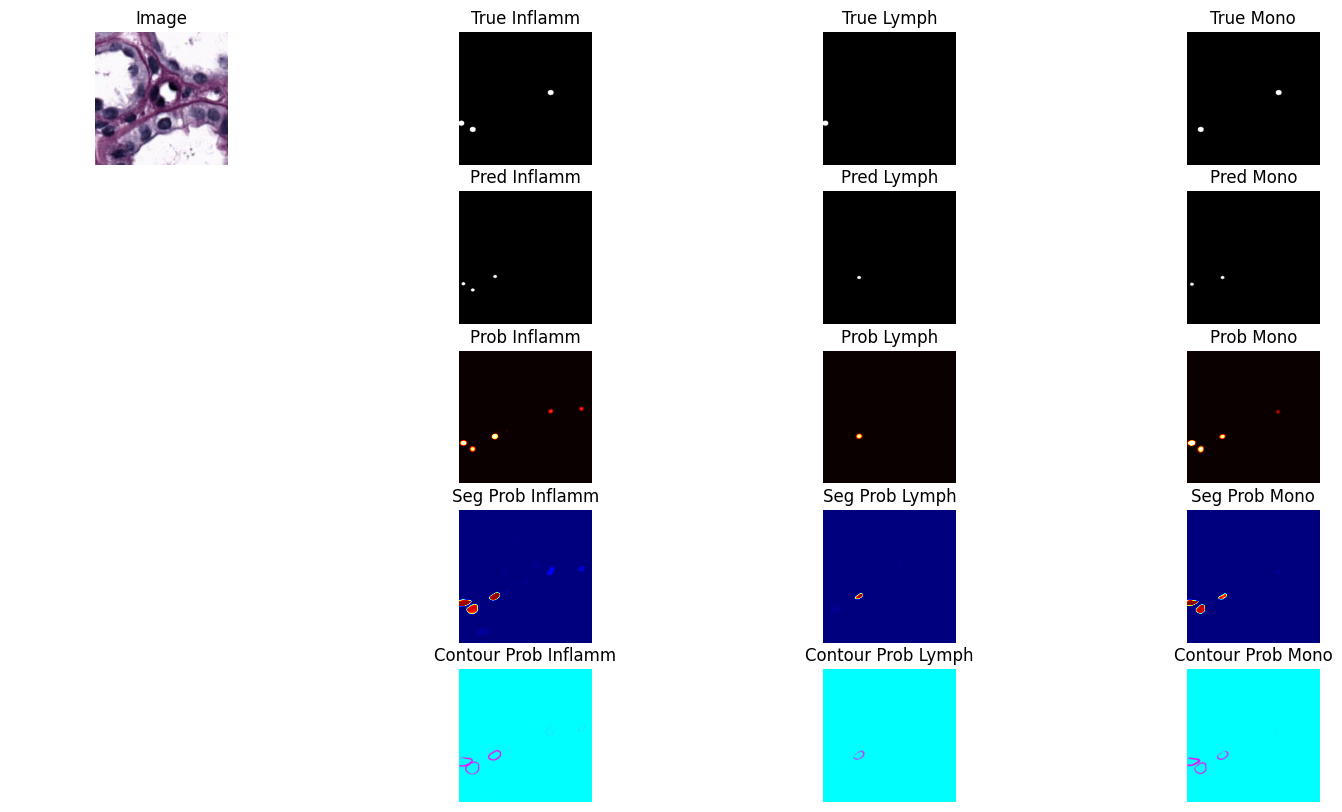

validation:   0%|          | 1/2925 [00:00<19:29,  2.50it/s]|2025-02-11|17:24:54.729| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05882353341579433..1.0000000236034394].


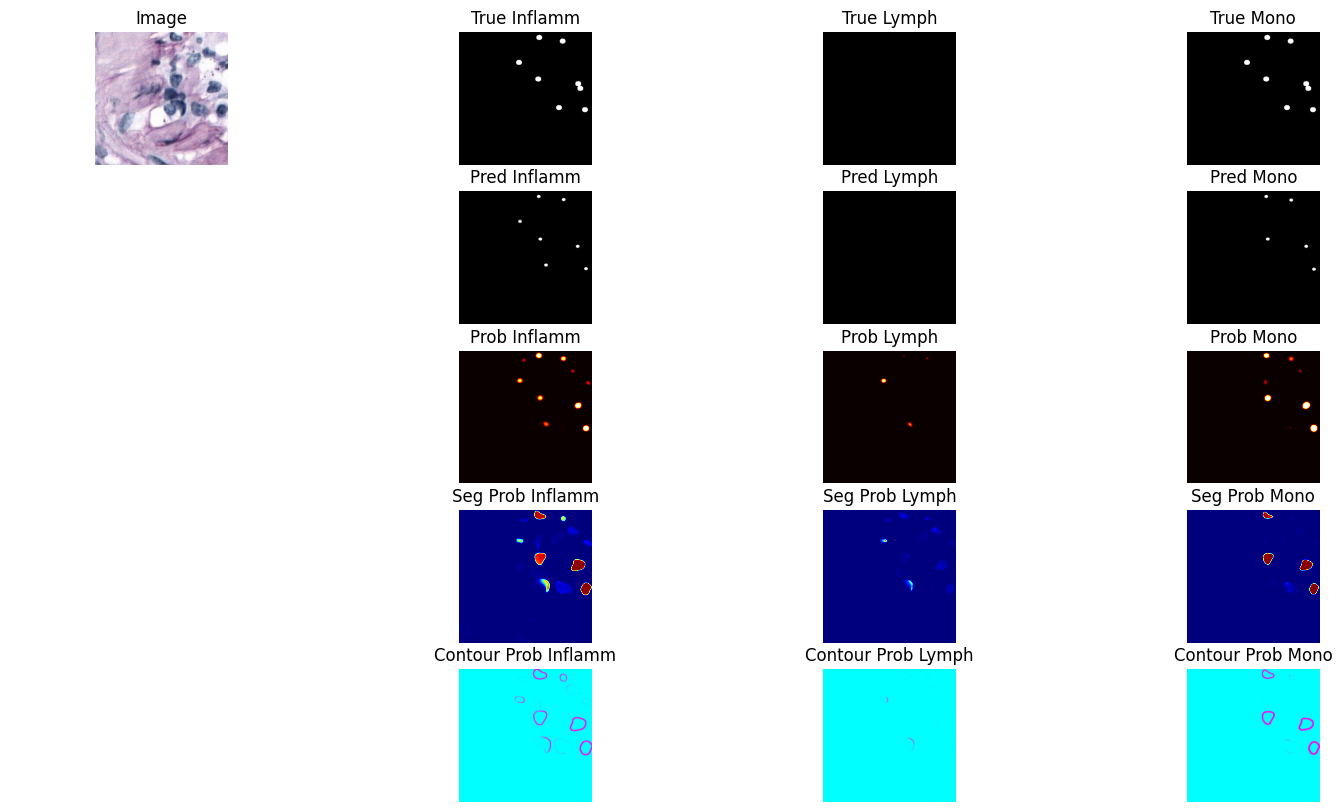

validation:   0%|          | 2/2925 [00:00<18:37,  2.62it/s]|2025-02-11|17:24:55.078| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10980393218994139..1.0000000236034394].


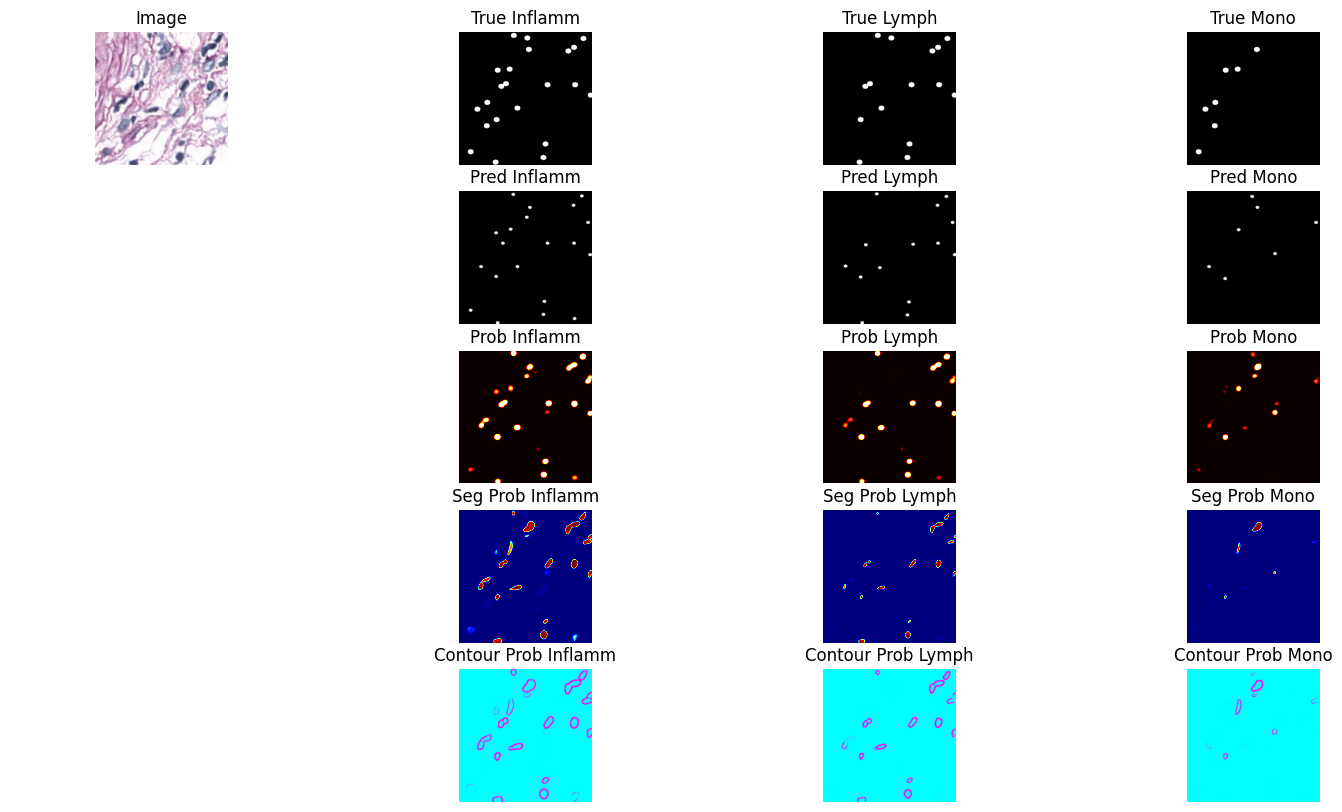

validation:   0%|          | 3/2925 [00:01<18:08,  2.69it/s]|2025-02-11|17:24:55.714| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05490196061134334..1.0000000236034394].


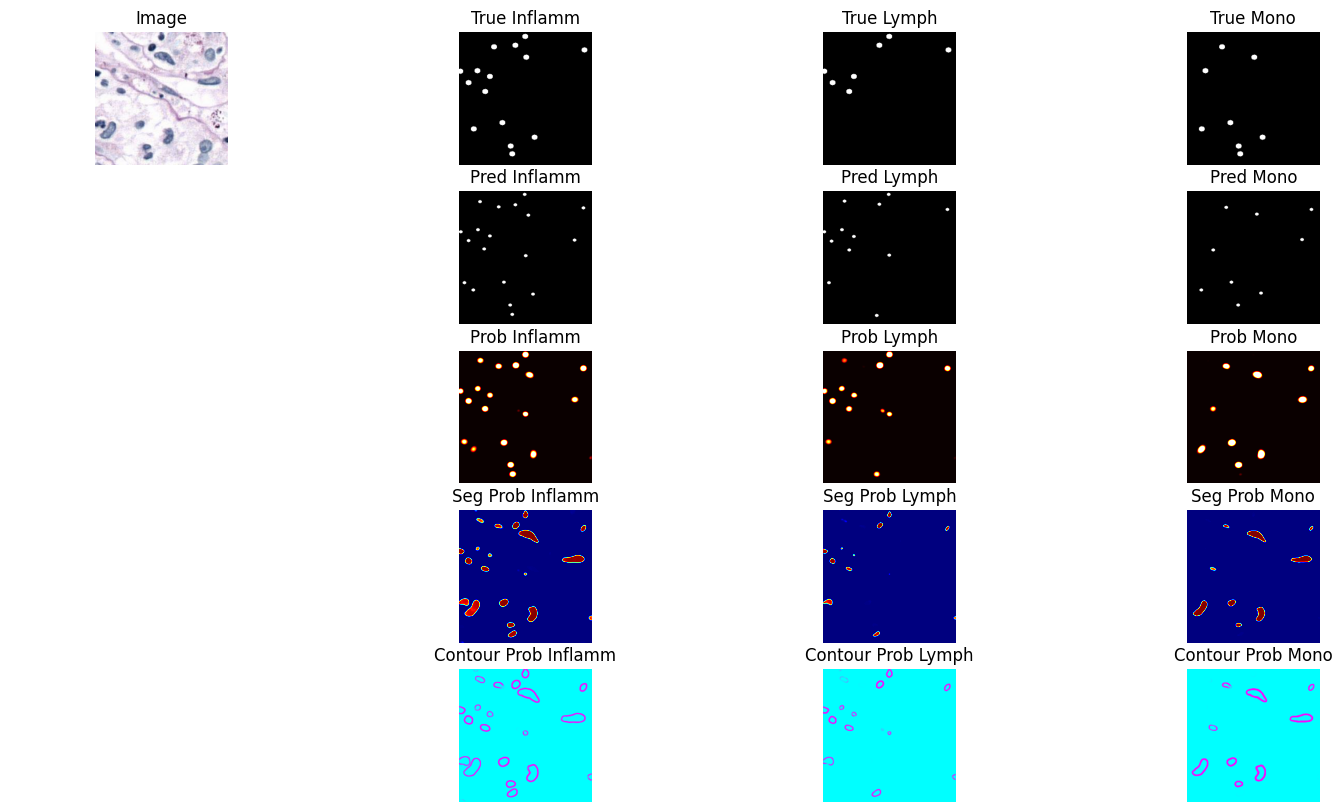

validation:   0%|          | 4/2925 [00:01<23:01,  2.12it/s]|2025-02-11|17:24:56.074| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.288818357065736e-08..1.0000000236034394].


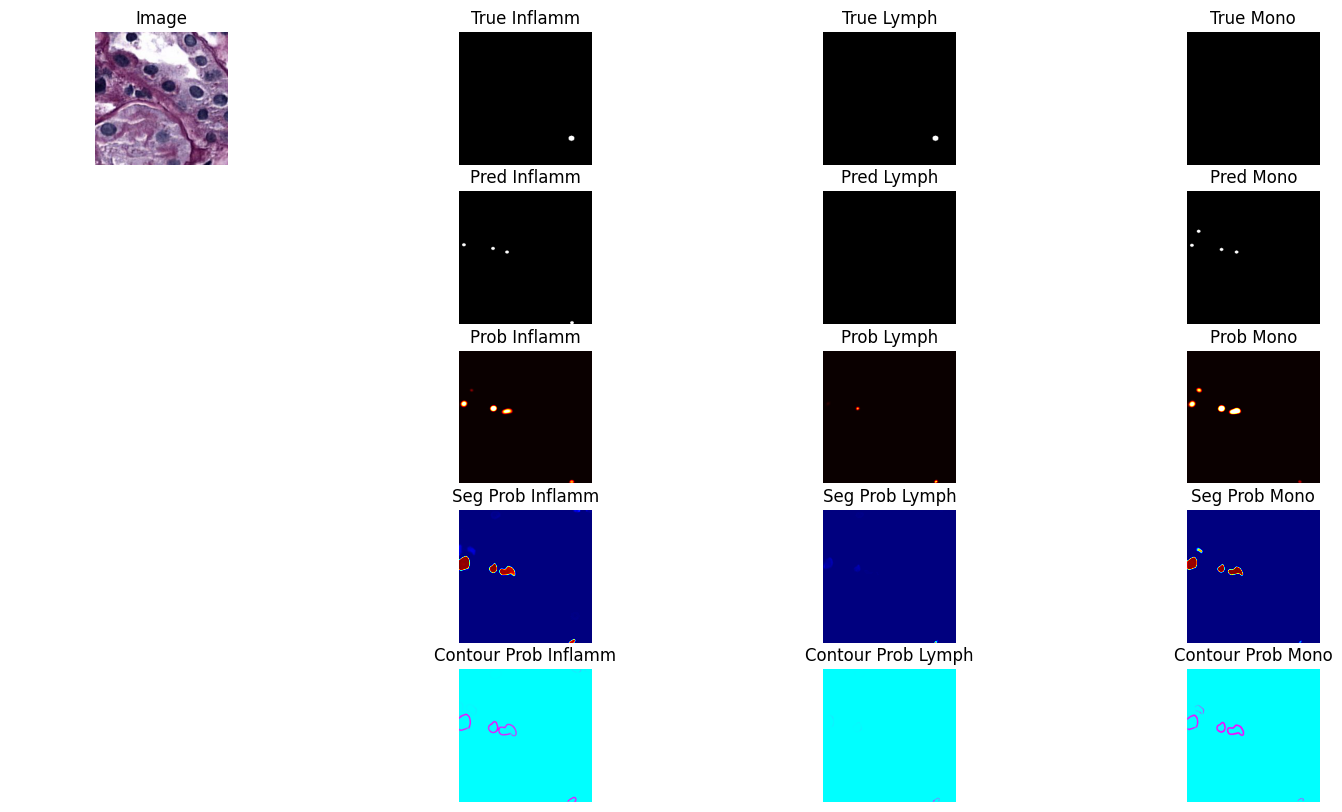

validation:   0%|          | 5/2925 [00:02<20:57,  2.32it/s]|2025-02-11|17:24:56.414| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.288818357065736e-08..1.0000000236034394].


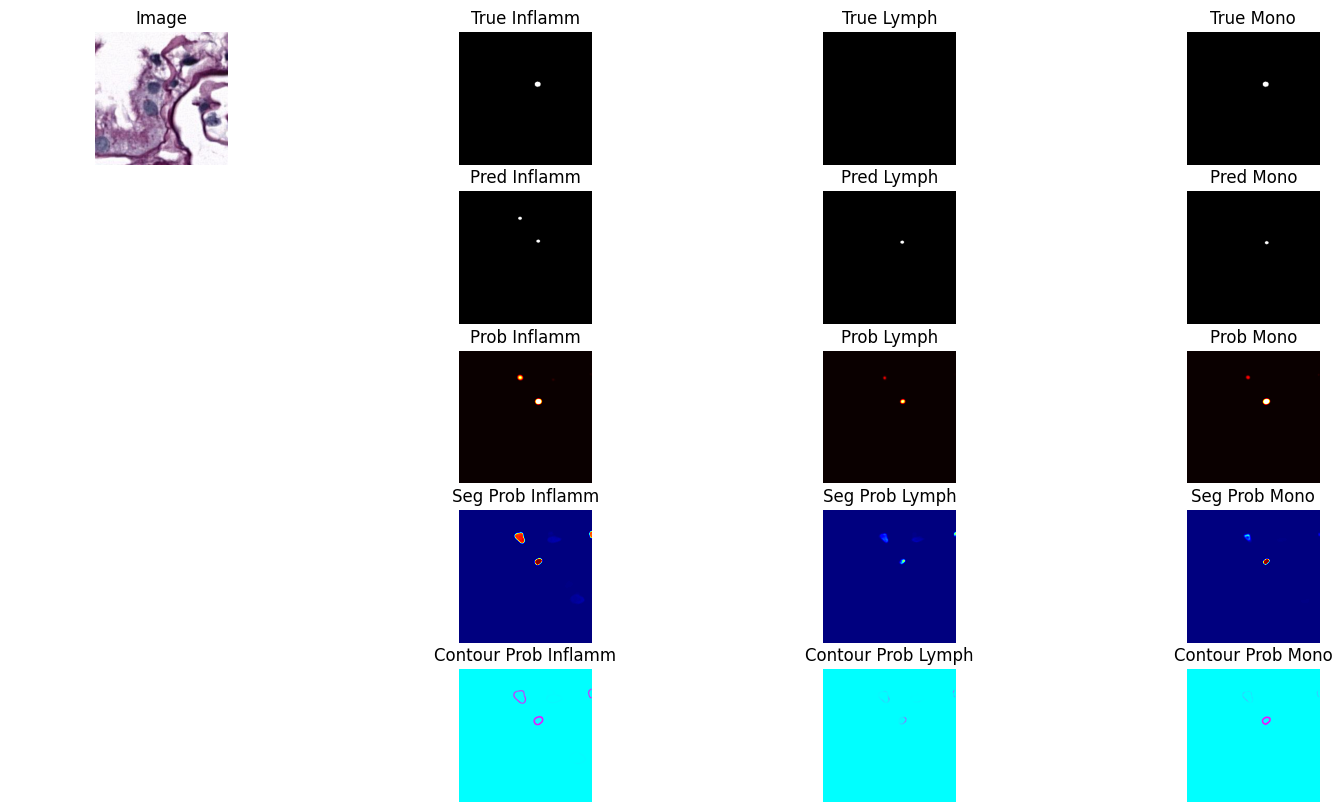

validation:   0%|          | 6/2925 [00:02<19:28,  2.50it/s]|2025-02-11|17:24:56.776| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.18823529946804046..1.0000000236034394].


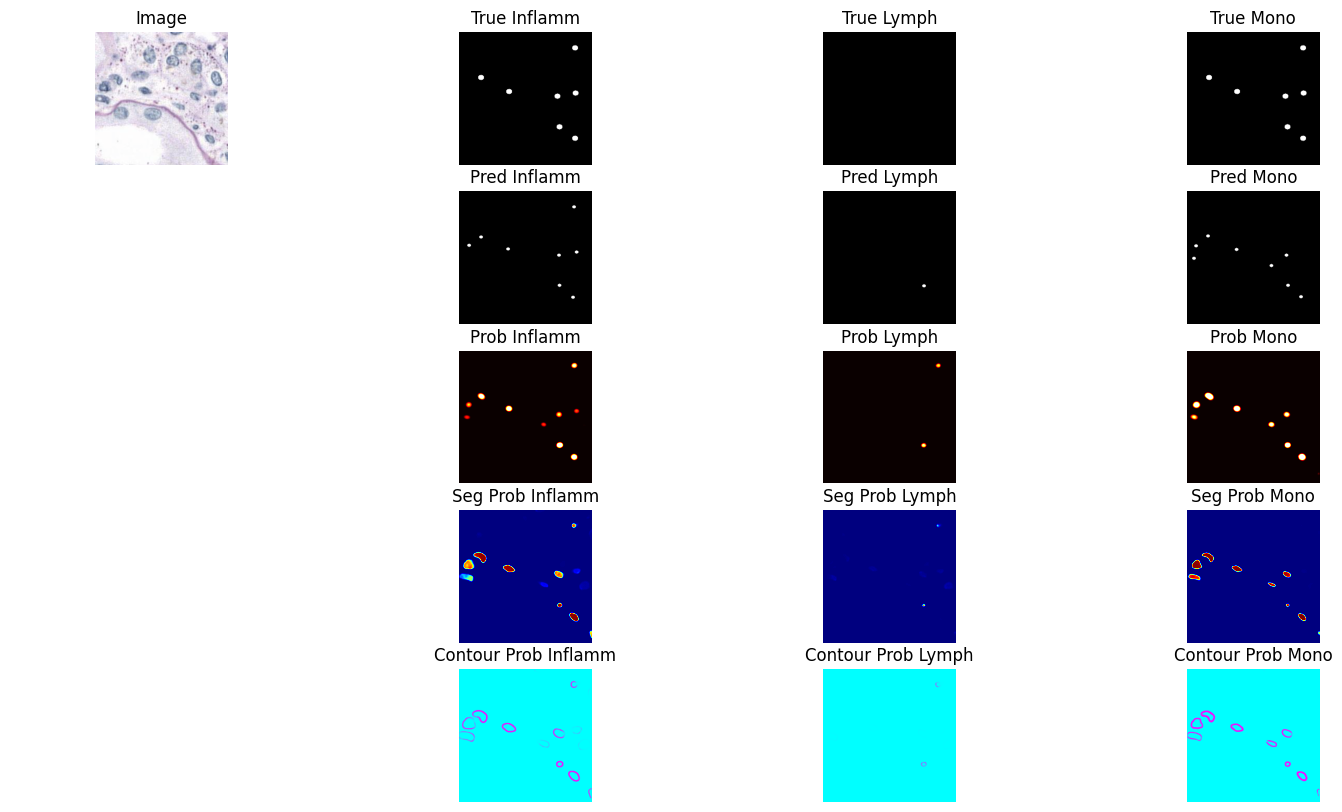

In [8]:
train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=run_config["val_fold"],
    dataset_name="multitask",
    batch_size=1,
    disk_radius=11,
)

for i, data in enumerate(
    tqdm(val_loader, desc="validation", leave=False)
):

    fig, axes = plt.subplots(5, 4, figsize=(18, 10))

    images = data["image"].cuda().float()
    inflamm_true_masks = data['inflamm_centroid_mask'].numpy(force=True)
    lymph_true_masks = data['lymph_centroid_mask'].numpy(force=True)
    mono_true_masks = data['mono_centroid_mask'].numpy(force=True)

    with torch.no_grad():
        inflamm_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        lymph_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        mono_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        inflamm_seg_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        lymph_seg_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        mono_seg_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        for model in models:
            logits_pred = model(images)
            # head_1_logits = logits_pred[:, 0:1, :, :]
            # head_2_logits = logits_pred[:, 1:2, :, :]
            # head_3_logits = logits_pred[:, 2:3, :, :]
            head_1_logits = logits_pred[:, 2:3, :, :]
            head_2_logits = logits_pred[:, 5:6, :, :]
            head_3_logits = logits_pred[:, 8:9, :, :]

            inflamm_seg_logits = logits_pred[:, 0:1, :, :]
            lymph_seg_logits = logits_pred[:, 3:4, :, :]
            mono_seg_logits = logits_pred[:, 6:7, :, :]

            _inflamm_prob = activation_dict["head_1"](head_1_logits)
            _lymph_prob = activation_dict["head_2"](head_2_logits)
            _mono_prob = activation_dict["head_3"](head_3_logits)

            _inflamm_seg_prob = activation_dict["head_1"](inflamm_seg_logits)
            _lymph_seg_prob = activation_dict["head_2"](lymph_seg_logits)
            _mono_seg_prob = activation_dict["head_3"](mono_seg_logits)

            inflamm_prob += _inflamm_prob.detach().cpu()
            lymph_prob += _lymph_prob.detach().cpu()
            mono_prob += _mono_prob.detach().cpu()

            inflamm_seg_prob += _inflamm_seg_prob.detach().cpu()
            lymph_seg_prob += _lymph_seg_prob.detach().cpu()
            mono_seg_prob += _mono_seg_prob.detach().cpu()

            inflamm_contour_prob = torch.sigmoid(logits_pred[:, 1:2, :, :]).detach().cpu()
            lymph_contour_prob = torch.sigmoid(logits_pred[:, 4:5, :, :]).detach().cpu()
            mono_contour_prob = torch.sigmoid(logits_pred[:, 7:8, :, :]).detach().cpu()

        inflamm_prob /= len(models)
        lymph_prob /= len(models)
        mono_prob /= len(models)
        inflamm_seg_prob /= len(models)
        lymph_seg_prob /= len(models)
        mono_seg_prob /= len(models)

    processed_output = multihead_det_post_process_batch(
        inflamm_prob,
        lymph_prob,
        mono_prob,
        thresholds=[0.5, 0.5, 0.5],
        min_distances=[13, 11, 13],
    )

    # processed_output = multihead_det_post_process_batch_experiment(
    #     inflamm_prob,
    #     lymph_prob,
    #     mono_prob,
    #     inflamm_seg_prob,
    #     lymph_seg_prob,
    #     mono_seg_prob,
    #     thresholds=[0.4, 0.4, 0.4],
    #     min_distances=[11, 11, 11],
    # )


    images = images.numpy(force=True)[0]
    images = np.moveaxis(images, 0, 2)
    images = imagenet_denormalise(images)

    axes[0][0].imshow(images)
    axes[0][0].set_title("Image")

    axes[0][1].imshow(inflamm_true_masks[0][0], cmap="gray")
    axes[0][1].set_title("True Inflamm")

    axes[2][1].imshow(inflamm_prob[0][0], cmap="hot")
    axes[2][1].set_title(f"Prob Inflamm")

    axes[0][2].imshow(lymph_true_masks[0][0], cmap="gray")
    axes[0][2].set_title("True Lymph")

    axes[0][3].imshow(mono_true_masks[0][0], cmap="gray")
    axes[0][3].set_title("True Mono")

    axes[2][3].imshow(mono_prob[0][0], cmap="hot")
    axes[2][3].set_title(f"Prob Mono")

    axes[1][2].imshow(
        dilate_mask(processed_output["lymph_mask"][0], 7), cmap="gray"
    )
    axes[1][2].set_title("Pred Lymph")

    axes[1][3].imshow(
        dilate_mask(processed_output["mono_mask"][0], 7), cmap="gray"
    )
    axes[1][3].set_title("Pred Mono")

    axes[1][1].imshow(
        dilate_mask(processed_output["inflamm_mask"][0], 7),
        cmap="gray",
    )
    axes[1][1].set_title("Pred Inflamm")

    axes[2][2].imshow(
        lymph_prob[0][0],
        cmap="hot",
    )
    axes[2][2].set_title(f"Prob Lymph")

    axes[3][1].imshow(
        inflamm_seg_prob[0][0],
        cmap="jet",
    )
    axes[3][1].set_title(f"Seg Prob Inflamm")

    axes[3][2].imshow(
        lymph_seg_prob[0][0],
        cmap="jet",
    )
    axes[3][2].set_title(f"Seg Prob Lymph")

    axes[3][3].imshow(
        mono_seg_prob[0][0],
        cmap="jet",
    )
    axes[3][3].set_title(f"Seg Prob Mono")

    axes[4][1].imshow(inflamm_contour_prob[0][0], cmap="cool")
    axes[4][1].set_title(f"Contour Prob Inflamm")

    axes[4][2].imshow(lymph_contour_prob[0][0], cmap="cool")
    axes[4][2].set_title(f"Contour Prob Lymph")

    axes[4][3].imshow(mono_contour_prob[0][0], cmap="cool")
    axes[4][3].set_title(f"Contour Prob Mono")

    for ax in axes.ravel():
        ax.axis("off")
    plt.show()

    if i > 5:
        break